In [1]:
from math import pi
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import wavio
import IPython
import rir_generator as RG

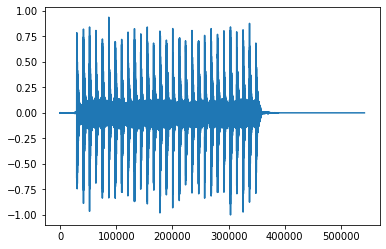

In [2]:
file = wavio.read("台北帝國intro.wav")
fixed_data = file.data[:, 0]
data = fixed_data.astype(np.float32, order='C') / 32767.0

plt.plot(data)
plt.show()

IPython.display.display(IPython.display.Audio("台北帝國intro.wav", rate = file.rate))

In [3]:
frameSize = 2048
stepSize = 128

padding = len(data) % stepSize
inputData = np.append(data, np.zeros(padding))
outputData = np.zeros(len(inputData))

iteration = (len(inputData) // stepSize) - (frameSize // stepSize) + 1

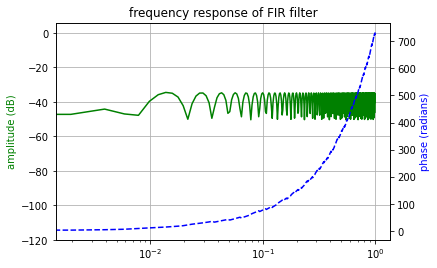

In [4]:
c = 340             # Sound velocity (m/s))
fs = file.rate      # Sample frequency (samples/s)
r = [10, 1.5, 2]     # Receiver position [x y z] (m)
s = [0,  5,   10]     # Source position [x y z] (m)
L = [30, 10,  20]     # Room dimensions [x y z] (m)
beta = 1.1           # Reverberation time (s)
n = frameSize       # Number of samples

taps = RG.rir_generator(c, fs, r, s, L, beta=beta, nsample=n)

w, h = signal.freqz(taps)

amplitude = 20 * np.log10(abs(h))
angle = np.unwrap(np.angle(h))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plt.title('frequency response of FIR filter')
plt.xlabel(r'normalized frequency (x$\pi$rad/sample)')

ax1.plot(w/max(w), amplitude, 'g')
ax1.set_ylabel('amplitude (dB)', color='g')
ax1.set_ylim(-120, 6)
ax1.grid()

ax2.plot(w/max(w), angle, 'b--')
ax2.set_ylabel('phase (radians)', color='b')

plt.xscale("log")
plt.show()

In [5]:
dataSet = np.zeros([iteration, frameSize])
Hn = np.fft.rfft(taps)

for i in range(iteration):
    start = i * stepSize
    end = start + frameSize
    dataSet[i] = inputData[start:end]

    Xn = np.fft.rfft(dataSet[i])
    Yn = np.multiply(Xn, Hn)
    yn = np.fft.irfft(Yn)
    
    start = i * stepSize
    end = start + stepSize
    outputData[start:end] = yn[0:stepSize]

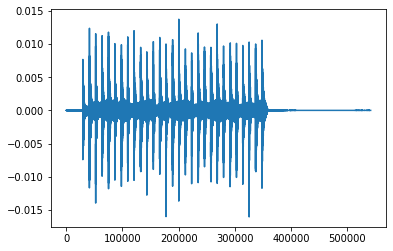

In [6]:
wavio.write("fft_fir.wav", outputData, file.rate, sampwidth=3)

plt.plot(outputData)
plt.show()

IPython.display.display(IPython.display.Audio("fft_fir.wav", rate=file.rate))

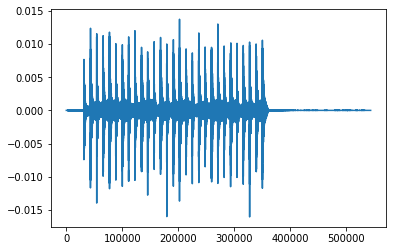

In [7]:
outputData = signal.convolve(taps, data)

wavio.write("fir.wav", outputData, file.rate, sampwidth=3)

plt.plot(outputData)
plt.show()

IPython.display.display(IPython.display.Audio("fir.wav", rate=file.rate))